# Robot control systems

Robots are equipped with various actuators that receive inputs and sensors that provide outputs. A robot's computer faces the task of deciding what signals to send to the actuators based on the measured sensor readings such that a robot executes desired behavior. This task of controlling the robot must address various challenges such as measurement noise, inaccurate robot models, non-ideal actuators and external disturbances. Control theory offers a systematic approach to address this challenge. 

<img src="tp3/media/system.png" alt="A system" width="500"/>


A robot can be modelled as a _system_ taking inputs $u_k$ and producing outputs $y_k$, where $k \in \mathbb{Z}$ is the discrete time index. We will consider discrete-time systems throughout this assignment. Continuous-time systems can be well approximated by discrete-time systems via numerical integration methods, such as Euler integration or Runge-Kutta methods.

Let us start with a simple, yet widely-applicable class of systems, namely a discrete-time linear time invariant (LTI) system. It can be expressed the the so-called state-space form as follows

$x_{k+1} = Ax_k + Bu_k$,

and the output is also given by a linear equation

$y_k = Cx_k + Du_k$.

The matrix $D = 0$ most often in practice. The system is called linear because the system dynamics is linear in $x$ and $u$, the input-output relationship is affine, and time-invariant because the dynamics parameters $A, B, C$, and $D$ are assumed to not depend on time. Moreover, if the system is fully-observed, i.e., all of its states are measured: $C = I$.

#### Pure Feedforward Control

Suppose that we have a $y_{\mathrm{des},k}$ be a discrete-time desired output trajectory for our system. One of the simplest controllers that can we can develop to execute this task is an `open-loop' feedforward controller, whose schematic is shown below.

<img src="tp3/media/FF.png" alt="Feedforward control system" width="500"/>

Here, the feedforward controller computes the appropriate control input to apply depending on the desired system output $y_{\mathrm{des},k}$. It often uses knowledge of the system state $x_k$ and inverts the system dynamics to compute the control actions to be applied. 

For example, for the discrete-time system presented above at state $x_k$, the linear equation below can be solved (in a least-squares sense if not exactly solvable) for $u_k$ to compute the feedforward control action for trajectory following. We are assuming that $D = 0$ here.

$y_{\mathrm{des},k+1} = C(Ax_k + Bu_k)$.

Pros of pure feedforward control: 
- FF control systems are simple.
- Less likely to result in catastrophically unstable system.
- May not require sensors and state estimation.
- Can follow complex desired trajectories.

Cons of pure feedforward control:
- Rarely works alone in practice.
- Sensitive to initial state estimation error and model errors.
- Inverting system dynamics may not always be possible.

## Feedback control

Feedforward control is often insufficient to track the desired trajectory in the presence of noise, model errors and disturbances. We need a negative feedback loop that measures the error between the desired trajectory and the real trajectory and uses it to reduce tracking errors. Negative feedback loops, being widely and frequently used, are nearly synonymous with the field of control.

<img src="tp3/media/FB.png" alt="Feedback control system" width="500"/>

For LTI systems, a common form of negative feedback is the linear state feedback law 

$u = K (x_\mathrm{des} - x)$.

If the control task involves taking the system to the origin ($x_\mathrm{des} = 0$),the closed-loop system is then described by the following discrete-time LTI system:

$x_{k+1} = (A - BK)x_k$

$y_k = Cx_k$

For regulation tasks, when $x_\mathrm{des}$ is fixed, it is always possible to redefine the origin of the system to formulate all regulation problems as taking the system to the origin.

In practice, feedforward controllers and feedback controllers are both combined as shown below to leverage both their benefits.

<img src="tp3/media/FF_FB.png" alt="Feedback control system" width="700"/>

Feedforward terms permit tracking complex trajectories using an imperfect system model while the feedback terms stabilize the system around the desired setpoint mitigating the negative effects of model inaccuracies and external disturbances.

## Linear Quadratic Regulator

Linear Quadratic Regulator (LQR) is a widely used and popular controller that systematically results in a stable feedback controller and scales well to controlling high-dimensional systems (such as Humanoid robots). LQR computes control actions that minimizes the cost function, (assuming that the system is being stabilized around the origin):

$J = \sum_{t=0}^{\infty} (x_t^T Q x_t + u_t^T R u_t)$,

where $Q$ and $R$ are positive definite matrices (often just diagonal matrices), and chosen by the users.  The LQR controller is the optimal feedback gain that minimizes this cost function.  Choosing high-value of $Q$ relative to $R$ results in aggressive control behavior and faster state convergence to the origin. While this is often desirable, choosing $Q$ to be too high relative to $R$ can make the controller compute actions that exceed actuator limits and also makes it sensitive to process and measurement noise, which can result in a chattering behavior. Therefore an appropriate trade-off between control performance and robustness to noise and actuator limits needs to be made. The LQR controller can be computed using the following steps:

1. Solve the discrete-time Riccati equation for the system:
 
    $ P = A^T P A - A^T P B (B^T P B + R)^{-1} B^T P A + Q $ 

2. Compute feedback gain

    $K = (R + B^T P B)^{-1} B^T P A$

3. The control law is then:
    
    $ u = -K x $

LQR (and linear control in general) is a useful tool even for controlling nonlinear systems. Nonlinear systems are often locally linearizable, using their first derivatives. The controller design is then performed for this linearized system and can be effective as long as the nonlinear system remains close to the linearization point.

In this exercise, we will consider the nonlinear system cart-pole, linearized around the upright position. The state of the system is 
$x = \begin{bmatrix} x \\ \dot{x} \\ \theta \\ \dot{\theta} \end{bmatrix}$.

he system dynamics and the linearization around the upright position can be found in 
https://courses.ece.ucsb.edu/ECE594/594D_W10Byl/hw/cartpole_eom.pdf. (Hint: Use equations 22 and 23.)

Assume that $M = 1$, $m_p = 1$ and $L = 1$.

In [2]:
import time
import numpy as np
from numpy.linalg import inv,norm,pinv,svd,eig
from scipy.linalg import solve_discrete_are
import matplotlib.pylab as plt

g = 9.81
M = 1
m = 1
l = 1

### Linearized system of equations in Continuous-Time

The linearized system's dynamics in terms of the state variables (from the pdf linked above) is reproduced below.

$\dot{x} = \dot{x}$

$\ddot{x} = \frac{m_p}{M}g \theta + \frac{1}{M} u$

$\dot{\theta} = \dot{\theta}$

$\ddot{\theta} = \frac{M+m_p}{M} \frac{g}{L} \theta + \frac{1}{ML}$



### Exercise 3.1 Discretize the linearized equations using forward Euler method.

Use Ts (time-step) of 0.01s

$x_{k+1} = Ax_k + Bu_k$,

In [3]:
# Compute the A and B matrices for the linearized system around the upright position
Ts = 0.01
A = np.array([[1, 1, 0, 0],
              [0, 1, (m*g)/M, 0],
              [0, 0, 1, 1],
              [0, 0, g*(M + m)/(l*M), 1]])
B = np.array([[0], [1/M], [0], [1/(l*M)]])
Q, R = np.eye(4), np.eye(1)



Compute the LQR feedback gains for the cart-pole system linearized at the upright position. Stabilize the system at the upright position the LQR controller, starting from a state $x_0 = \begin{bmatrix} 0, 0.0.1, 0 \end{bmatrix}^T$. Simulate the nonlinear system for 10 seconds and plot the state trajectories. The actuator forces $u \in [-5, 5]$ N, verify if your controller satisfies these limits. 

(Hint: use scipy.linalg.solve_discrete_are to solve the Riccati equation)

1. Solve the discrete-time Riccati equation for the system:
 
    $ P = A^T P A - A^T P B (B^T P B + R)^{-1} B^T P A + Q $ 

2. Compute feedback gain

    $K = (R + B^T P B)^{-1} B^T P A$

3. The control law is then:
    
    $ u = -K x $

In [4]:
P = solve_discrete_are(A,B,Q,R)
K = inv(R+B.T @ P @ B) @ (B.T @ P @ A)

In [5]:
# nonlinear system, Forward Euler
def nls_cartpole(x,u, Ts):
    M = 1
    m = 1
    l = 1
    xcdot = x[1]
    thetadot = x[3]
    xc = x[0]
    theta = x[2]
    s = np.sin(theta)
    c = np.cos(theta)
    u = np.clip(u, -5, 5)
    xcddot = (-s*(m*l)*c*thetadot**2 + s*m*c*g + u)/(-m*c**2 + M + m)
    thetaddot = (-s*(m*l)*c*thetadot**2 + s*g*(M+m) + u*c)/(l*(-m*c**2 + M + m))
    xc = xc + Ts*xcdot
    xcdot = xcdot + Ts*xcddot
    theta = theta + Ts*thetadot
    thetadot = thetadot + Ts*thetaddot
    return np.hstack([xc,xcdot,theta,thetadot])

In [6]:
Nsteps = 1000
# simulate the system
x0 = np.array([0,0,0.1,0])
x_traj = []
x_traj.append(x0)
u_traj = []
for i in range(Nsteps):
    u = -K @ x_traj[-1]
    x_step = nls_cartpole(x_traj[-1],u,Ts)
    u_traj.append(u)
    x_traj.append(x_step)

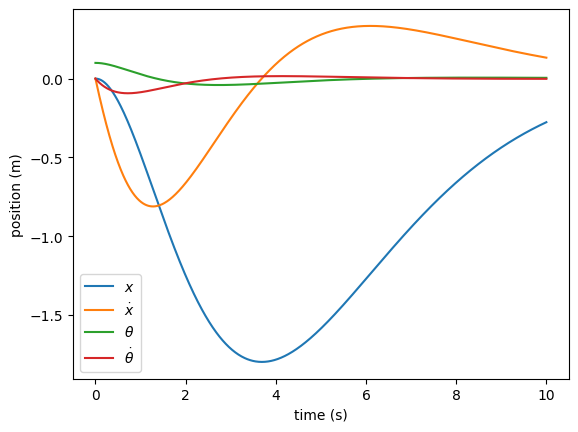

In [7]:
# plot the simulated trajectory and the desired trajectory
plt.figure()
plt.plot(np.linspace(0,Nsteps*Ts,Nsteps+1),[x[0] for x in x_traj])
plt.plot(np.linspace(0,Nsteps*Ts,Nsteps+1),[x[1] for x in x_traj])
plt.plot(np.linspace(0,Nsteps*Ts,Nsteps+1),[x[2] for x in x_traj])
plt.plot(np.linspace(0,Nsteps*Ts,Nsteps+1),[x[3] for x in x_traj])
plt.legend(['$x$', '$\dot{x}$', '$\\theta$', '$\dot{\\theta}$'])
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

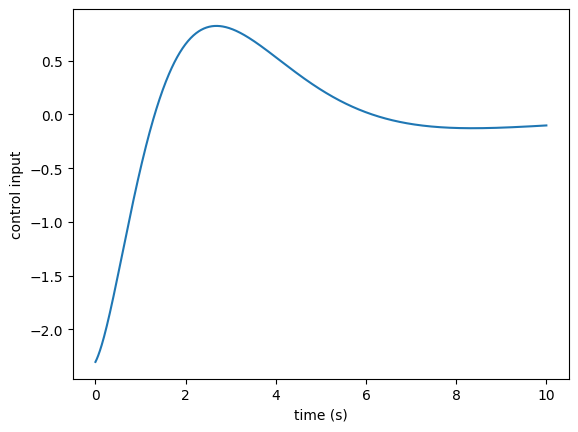

In [8]:
# plot the control input
plt.figure()
plt.plot(np.linspace(0,Nsteps*Ts,Nsteps),u_traj)
plt.xlabel('time (s)')
plt.ylabel('control input')
plt.show()

## System stability

Let us consider regulation problem, where the desired trajectory being tracked is a fixed set-point. Without loss of generality (why?) for regulation problems, we can assume that we want the system to reach the origin. A system 

$x_{k+1} = A x_k$,

is said to be asymptotically stable if $\lim_{k \to \infty} x_k = 0$. For an LTI system, checking for stability amounts to checking if the magnitude of all the eigenvalues of the matrix $A$ is strictly less than 1.0. Then the system is said to be strictly stable. If one eigenvalue has a magnitude equal to 1, the system is said to be marginally stable. If more than one eigenvalue has a magnitude equal to 1, the system may be unstable. If even one eigenvalue magnitude is strictly greater than one, the system is unstable.

Note that a closed loop LTI system is given by

$x_{k+1} = A_\mathrm{cl} x_k$,

where $A_\mathrm{cl} = A - B K$. Therefore, stability of the closed-loop LTI systems is characterized using the eigenvalues of the matrix $A_\mathrm{cl}$. 

It is important to characterize the stability of the feedback system, as it is a property that implies 'good behavior' of the closed-loop system, i.e. that it will not diverge or oscillate from the desired set-point.  Unstable systems can be dangerous in practice. 


### Exercise 3.3

Compute the eigenvalues of the closed-loop LQR controller and the linearized system computed previously in Exercise 3.2.

In [19]:
lamb = eig(A-B@K)
np.abs(lamb.eigenvalues)

array([0.29653789, 0.56736253, 0.56736253, 0.18093682])

In [20]:
# Compute the region of attraction of the LQR controller

# uniform grid of initial conditions in a box. Keeping x and xdot fixed at 0, and gridding over theta and thetadot. Using CasADi to save hours of computation time. The entire loop is unrolled, and a function is created. This will be much faster than Python because it is executed in and executed in CasADi's virtual machine in C++.
import casadi as cs
import copy
def nls_casadi_clipped_loopunrolled_cartpole(x, K, Ts, N_steps):
    M = 1
    m = 1
    l = 1
    for _ in range(N_steps):
        u = -K @ x
        u = cs.fmin(cs.fmax(u, -5), 5)
        s = cs.sin(x[2])
        c = cs.cos(x[2])
        xcddot = (-s*(m*l)*c*x[3]**2 + s*m*c*g + u)/(-m*c**2 + M + m)
        thetaddot = (-s*(m*l)*c*x[3]**2 + s*g*(M+m) + u*c)/(l*(-m*c**2 + M + m))
        x[0] = x[0] + Ts*x[1]
        x[1] = x[1] + Ts*xcddot
        x[2] = x[2] + Ts*x[3]
        x[3] = x[3] + Ts*thetaddot
    return x

x_sym = cs.SX.sym('x',4)
u_sym = cs.SX.sym('u',1)
x_next = nls_casadi_clipped_loopunrolled_cartpole(copy.deepcopy(x_sym), K,Ts, N_steps=5000)
nls_casadi_func = cs.Function('nls_casadi_func',[x_sym],[x_next])


In [21]:
x_sym

SX([x_0, x_1, x_2, x_3])

In [22]:

Ts = 0.01
N_steps = 1000
theta_lim = np.pi/3
thetadot_lim = 4
n_samples_each_axis = 201
theta_samples = np.linspace(-theta_lim, theta_lim, n_samples_each_axis)
thetadot_samples = np.linspace(-thetadot_lim, thetadot_lim, n_samples_each_axis)
# take cartesian product of theta_samples and thetadot_samples
theta_samples, thetadot_samples = np.meshgrid(theta_samples, thetadot_samples)
theta_samples = theta_samples.flatten()
thetadot_samples = thetadot_samples.flatten()
n_samples = len(theta_samples)

stable_initial_conditions = []
unstable_initial_conditions = []
roa_count = 0
for i in range(n_samples):
    x0 = np.array([0,0,theta_samples[i],thetadot_samples[i]])
    x_next = x0
    for i in range(1):
        u = -K @ x_next
        x_next = nls_casadi_func(x_next)
        if cs.norm_2(x_next) < 0.01:
            roa_count += 1
            stable_initial_conditions.append(x0)
            break
    final_state = x_next
    if cs.norm_2(final_state) > 0.5:
        unstable_initial_conditions.append(x0)

print(f"Estimated ROA volume fraction: {roa_count/n_samples:.2f}")

Estimated ROA volume fraction: 0.14


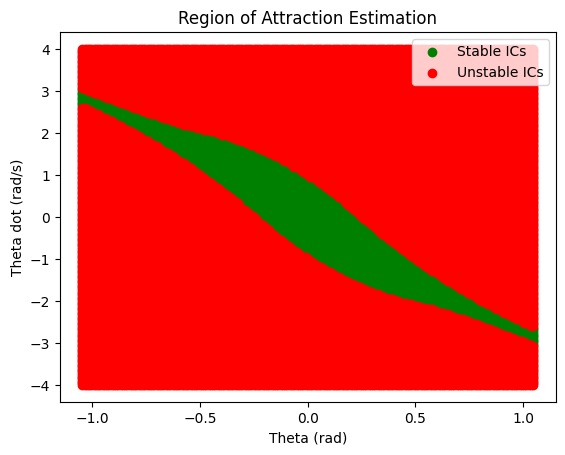

In [23]:
# plot stable and unstable initial conditions
plt.figure()
if stable_initial_conditions:
    stable_initial_conditions = np.array(stable_initial_conditions)
    plt.scatter(stable_initial_conditions[:,2], stable_initial_conditions[:,3], color='g', label='Stable ICs')
if unstable_initial_conditions:
    unstable_initial_conditions = np.array(unstable_initial_conditions)
    plt.scatter(unstable_initial_conditions[:,2], unstable_initial_conditions[:,3], color='r', label='Unstable ICs')
plt.xlabel('Theta (rad)')
plt.ylabel('Theta dot (rad/s)')
plt.legend()
plt.title('Region of Attraction Estimation')
plt.show()

## Optimal Control of Nonlinear System with Constraints

The previously discussed LQR controller works with a linearized system and does not take into account actuator limits. Optimal control is a framework that allows us to handle nonlinear systems and constraints in a systematic way. In this exercise, we will formulate and solve an optimal control problem for the nonlinear cart-pole system using multiple-shooting formulation via CasADi. 

CasADi is a symbolic framework for automatic differentiation and numerical optimization. It is widely used in robotics and control for solving optimal control problems. It provides a user-friendly interface for defining optimization problems and constraints, and it can efficiently compute gradients and Hessians using automatic differentiation.
    
To give a brief idea about CasADi's syntax, below is an example of a quadratic optimization problem with constraints. 

For a quick overview of the multiple shooting framework for solving OCP, check out the nice blogpost on the CasADi website https://web.casadi.org/blog/ocp/


In [68]:
# An example QP problem solved using Casadi
opti = cs.Opti()
x = opti.variable(2)  # optimization variable
Q = np.array([[1, 0], [0, 1]])
opti.minimize(0.5 * x.T @ Q @ x)  # objective
opti.subject_to(x[0] + x[1] == 1)  #
opti.subject_to(x[0] >= 0)  # inequality
opti.subject_to(-2 <= (x[1] <= 2))

opti.solver('ipopt')  # set solver
sol = opti.solve()  # solve the problem
x_sol = sol.value(x)

print('Optimal solution: x = ', x_sol)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        1
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 2.50e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [69]:
# nonlinear system, Forward Euler
def nls_casadi_cartpole(x,u, Ts):
    M = 1
    m = 1
    l = 1
    xcdot = x[1]
    thetadot = x[3]
    xc = x[0]
    theta = x[2]
    s = cs.sin(theta)
    c = cs.cos(theta)
    xcddot = (-s*(m*l)*c*thetadot**2 + s*m*c*g + u)/(-m*c**2 + M + m)
    thetaddot = (-s*(m*l)*c*thetadot**2 + s*g*(M+m) + u*c)/(l*(-m*c**2 + M + m))
    xc = xc + Ts*xcdot
    xcdot = xcdot + Ts*xcddot
    theta = theta + Ts*thetadot
    thetadot = thetadot + Ts*thetaddot
    return cs.vcat([xc,xcdot,theta,thetadot])

In [70]:
# Set up the Opti instance
opti = cs.Opti()

N = 200  # horizon length
nx = 4  # number of states

nu = 1  # number of inputs

X = opti.variable(nx, N+1)  # state trajectory
U = opti.variable(nu, N)    # control trajectory
Ts = 0.02  # sampling time

### Exercise 3.4: Implement the OCP problem

In [71]:
Q = np.diag([10, 1, 100, 1])  # state cost
R = np.diag([0.1])            # input cost
x0_val = np.array([0, 0, 0.1, 0])  # initial state

x0 = opti.parameter(nx)  # initial state parameter
opti.set_value(x0, x0_val)
opti.subject_to(X[:, 0] == x0)  # initial condition constraint

cost = 0
## Your code here.
# Impose the stagewise nonlinear dynamics constraints as equality constraint between timesteps and accumulate the linear quadratic cost over the horizon in the variable cost.

for k in range(N):
    x_next = nls_casadi_cartpole(X[:,k], U[:,k], Ts)
    opti.subject_to(X[:,k+1] == x_next)  # dynamics constraint
    cost += cs.mtimes([X[:,k].T, Q, X[:,k]]) + cs.mtimes([U[:,k].T, R, U[:,k]])  # stage cost accumulation

#terminal constraint
opti.subject_to(X[2:4, N] == np.array([0,0])) # require the pendulum to be upright at the end of the horizon
opti.minimize(cost)

In [72]:
opti.solver('ipopt', {"expand":True})  # set numerical solver

sol = opti.solve()

x_sol = sol.value(X)
u_sol = sol.value(U)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     3006
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1400

Total number of variables............................:     1004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      806
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

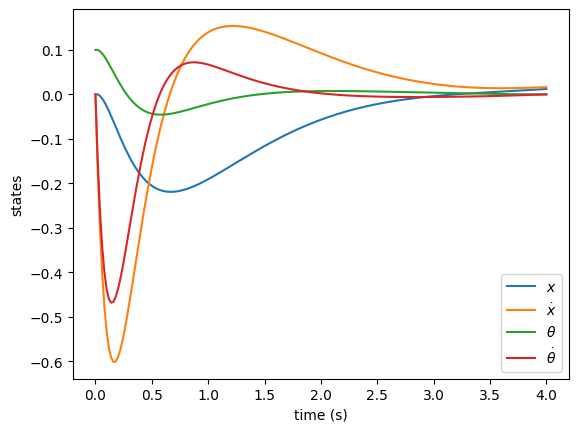

In [73]:
# plot the optimal state trajectory
plt.figure()
plt.plot(np.linspace(0,N*Ts,N+1),x_sol[0, :], label='$x$')
plt.plot(np.linspace(0,N*Ts,N+1),x_sol[1, :], label='$\\dot{x}$')
plt.plot(np.linspace(0,N*Ts,N+1),x_sol[2, :], label='$\\theta$')
plt.plot(np.linspace(0,N*Ts,N+1),x_sol[3, :], label='$\\dot{\\theta}$')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('states')
plt.show()

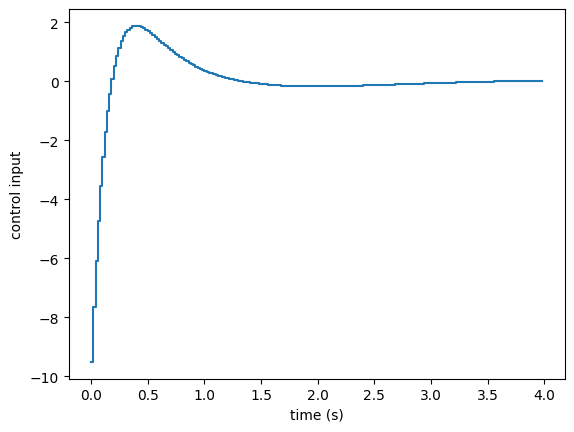

In [74]:
# Plot the control signal
plt.figure()
plt.step(np.linspace(0,(N-1)*Ts,N),u_sol, where='post')
plt.xlabel('time (s)')
plt.ylabel('control input')
plt.show()

### Ex 3.5 Swinging up the cartpole pendulum 

In [75]:
## Swing up
new_x0_val = np.array([0, 0, 3, 0])
opti.set_value(x0, new_x0_val)  # set new initial condition
sol = opti.solve()
x_sol_new_init = sol.value(X)
u_sol_new_init = sol.value(U) 

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     3006
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1400

Total number of variables............................:     1004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      806
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

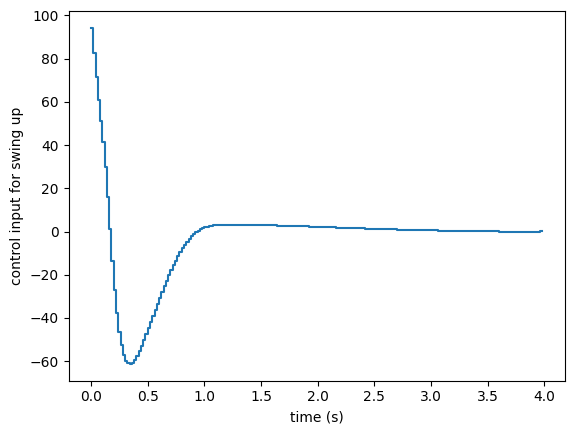

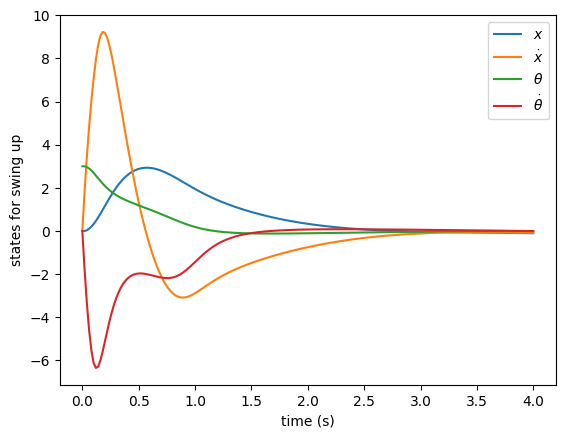

In [76]:
# Plot the control signal and the trajectory
plt.figure()
plt.step(np.linspace(0,(N-1)*Ts,N),u_sol_new_init, where='post')
plt.xlabel('time (s)')
plt.ylabel('control input for swing up')
plt.show()
plt.figure()
plt.plot(np.linspace(0,N*Ts,N+1),x_sol_new_init[0, :], label='$x$')
plt.plot(np.linspace(0,N*Ts,N+1),x_sol_new_init[1, :], label='$\\dot{x}$')
plt.plot(np.linspace(0,N*Ts,N+1),x_sol_new_init[2, :], label='$\\theta$')
plt.plot(np.linspace(0,N*Ts,N+1),x_sol_new_init[3, :], label='$\\dot{\\theta}$')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('states for swing up')
plt.show()

### Exercise 3.6 Adding actuator limits

Constrain the control action such that $u^* \in [-30, 30]$. $u^*$ denotes the optimal $u$ returned by the solver. Note that we have increased the control authority compared to the earlier LQR problem to make the swing-up problem easier.

In [80]:
# Add actuator constraints to ensure that it stays within [-30, 30]

### Your code here (should be one line)
for k in range(N):
    opti.subject_to( -30 <= (U[:,k] <= 30))

In [87]:
# Because the actuator limits are challenging for the upright problem, may require many random initializations 

x_init = np.random.randn(nx, N+1)
opti.set_initial(X, x_init)

sol = opti.solve()
x_sol_actuator_limited = sol.value(X)
u_sol_actuator_limited = sol.value(U)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     3006
Number of nonzeros in inequality constraint Jacobian.:      200
Number of nonzeros in Lagrangian Hessian.............:     1400

Total number of variables............................:     1004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      806
Total number of inequality constraints...............:      200
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4401704e+04 5.07e+00 5.77e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

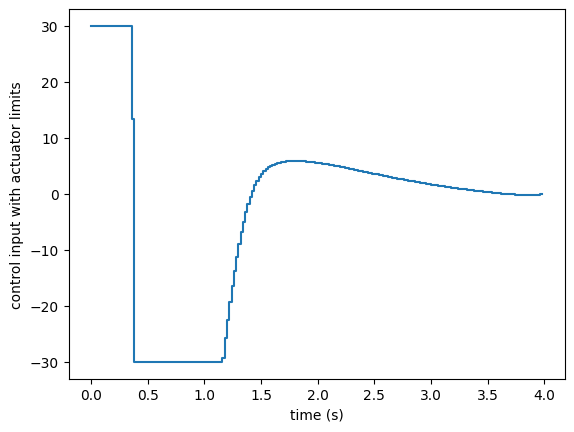

In [88]:
# Plot the values
plt.figure()
plt.step(np.linspace(0,(N-1)*Ts,N),u_sol_actuator_limited, where='post')
plt.xlabel('time (s)')
plt.ylabel('control input with actuator limits')
plt.show()  

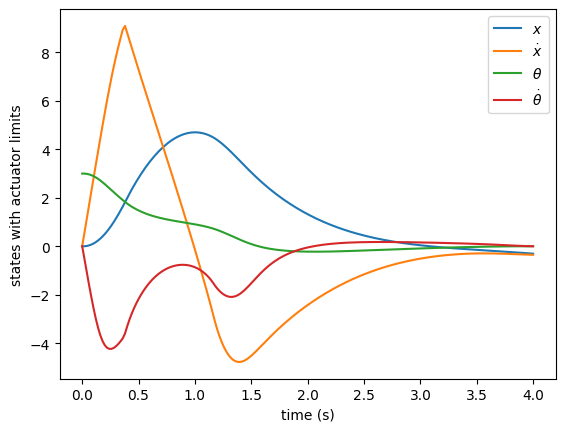

In [89]:
# plot states
plt.figure()
plt.plot(np.linspace(0,N*Ts,N+1),x_sol_actuator_limited[0, :], label='$x$')
plt.plot(np.linspace(0,N*Ts,N+1),x_sol_actuator_limited[1, :], label='$\\dot{x}$')
plt.plot(np.linspace(0,N*Ts,N+1),x_sol_actuator_limited[2, :], label='$\\theta$')
plt.plot(np.linspace(0,N*Ts,N+1),x_sol_actuator_limited[3, :], label='$\\dot{\\theta}$')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('states with actuator limits')
plt.show()